## Applied Machine Learning Side Project - Predicting Cancellation of a Hotel Reservation

This project uses machine learning skills I learned from CPSC 330 taught by Mike Gelbart at UBC to create a model to predict whether a hotel booking will be cancelled or not. The dataset used is from Kaggle (https://www.kaggle.com/jessemostipak/hotel-booking-demand).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [2]:
# Setup
df = pd.read_csv("hotel_bookings.csv")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)
df_train.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
1539,Resort Hotel,1,304,2015,September,36,3,0,3,40,...,No Deposit,NaN,NaN,0,Group,0.00,0,0,Canceled,2015-01-02
76995,City Hotel,0,3,2015,August,35,24,1,1,2,...,No Deposit,9.0,NaN,0,Transient,156.00,0,0,Check-Out,2015-08-26
51551,City Hotel,1,90,2016,May,21,21,1,1,2,...,No Deposit,9.0,NaN,0,Transient,116.10,0,0,Canceled,2016-03-21
8374,Resort Hotel,1,176,2016,September,39,24,2,1,2,...,No Deposit,240.0,NaN,0,Transient,122.33,0,0,Canceled,2016-04-04
54130,City Hotel,1,365,2016,July,28,7,0,2,2,...,Non Refund,1.0,NaN,0,Transient,62.00,0,0,Canceled,2015-10-21


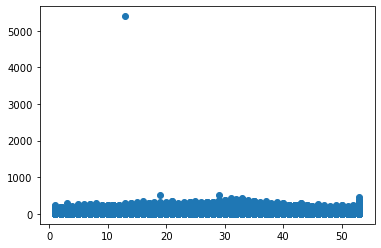

In [3]:
# Exploratory data analysis

#df_train.shape
#df_train.info()

plt.scatter(x=df_train['arrival_date_week_number'], y=df_train['adr'])

We see that there is an outlier for average daily rate ('adr') where one point has over 5000 dollars/day whereas the rest of the rates are less than 1000 dollars/day in the dataset. RobustScaler will be used to handle this outlier.

In [4]:
# Figure out what features we are going to use and categorize them
target_value = 'is_canceled'
numeric_features = ['lead_time','stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',
                   'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
                   'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests'
                   ]
numeric_features_robust = ['adr']
categorical_features = ['hotel', 'arrival_date_year', 'arrival_date_month', 'meal', 'market_segment',
                        'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type',
                       'customer_type']
drop_features = ['is_canceled', 'arrival_date_week_number', 'arrival_date_day_of_month', 'country', 'agent',
                'company', 'reservation_status', 'reservation_status_date']


X_train = df_train.drop(columns=drop_features)
y_train = df_train['is_canceled'] > 0

X_test = df_test.drop(columns=drop_features)
y_test = df_test['is_canceled'] > 0

In [5]:
#Fit baseline model - DummyClassifier
dc = DummyClassifier(strategy='prior')
dc.fit(None, y_train)
score = dc.score(None, y_train)
print('Score to beat (baseline) is: ' + str(score))

Score to beat (baseline) is: 0.6293973532121618


In [6]:
# Preprocessing pipeline construction - code adapted from CPSC 330 lecture 16
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
numeric_preprocessing_robust = make_pipeline(SimpleImputer(strategy='median'), 
                                      RobustScaler())
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="NULL"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('numeric_robust', numeric_preprocessing_robust, numeric_features_robust),
    ('categorical', categorical_preprocessing, categorical_features)
])
preprocessing.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['lead_time', 'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled',
                                  'booking_changes', 'days_in_waitin...
                                 ['adr']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NULL',
     

In [7]:
# code heavily adapted from CPSC 330 lecture 16
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + numeric_features_robust + ohe_columns
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,...,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
1539,1.867119,-0.931648,0.263873,63.883600,-0.260427,-0.07985,-0.181499,-0.103579,-0.091619,-0.338689,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
76995,-0.945907,0.070848,-0.785793,0.241019,4.749927,-0.07985,-0.181499,-0.103579,-0.091619,-0.338689,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
51551,-0.132840,0.070848,-0.785793,0.241019,-0.260427,-0.07985,-0.181499,-0.103579,-0.091619,-0.338689,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8374,0.670882,1.073344,-0.785793,0.241019,-0.260427,-0.07985,-0.181499,-0.103579,-0.091619,2.727409,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
54130,2.437201,-0.931648,-0.260960,0.241019,-0.260427,-0.07985,-0.181499,-0.103579,-0.091619,-0.338689,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [8]:
# trying out other classifiers to beat baseline - LogisticRegression
pipe_lr = Pipeline([
    ("preprocessing", preprocessing),
    ("lr", LogisticRegression(max_iter=1000))
])
pipe_lr.fit(X_train, y_train)
lr_score = pd.DataFrame(cross_validate(pipe_lr, X_train, y_train, return_train_score=True))
lr_score = lr_score['test_score'].mean()
print('Score with LogisticRegression is: ' + str(lr_score))

Score with LogisticRegression is: 0.811343089462728


In [9]:
# trying out other classifiers to beat baseline - LGBMClassifier
pipe_lgbm = Pipeline([
    ("preprocessing", preprocessing),
    ("lgbm", LGBMClassifier(random_state=999))
])
pipe_lgbm.fit(X_train, y_train)
lgbm_score = pd.DataFrame(cross_validate(pipe_lgbm, X_train, y_train, return_train_score=True))
lgbm_score = lgbm_score['test_score'].mean()
print('Score with LGBMClassifier is: ' + str(lgbm_score))

Score with LGBMClassifier is: 0.842585236847591


In [10]:
#tune for hyperparamters C and num_leaves for each respective Classifier using GridSearchCV
#for C
param_grid = {
    "lr__C" : [0.01, 1, 5, 10]
}

grid_search = GridSearchCV(pipe_lr, param_grid, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train);
best_c = grid_search.best_params_

#for num_leaves
param_grid = {
    "lgbm__num_leaves" : [10, 30, 50, 70]
}

grid_search = GridSearchCV(pipe_lgbm, param_grid, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train);
best_num_leaves = grid_search.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   37.6s finished


In [11]:
print('The results from hyperparameter tuning shows: ' + str(best_c) + ' and ' + str(best_num_leaves))

The results from hyperparameter tuning shows: {'lr__C': 5} and {'lgbm__num_leaves': 70}


In [12]:
# error bar analysis - LogisticRegression
pipe_lr2 = Pipeline([
    ("preprocessing", preprocessing),
    ("lr", LogisticRegression(C=5, max_iter=1000))
])
pipe_lr2.fit(X_train, y_train)
lr_score2 = pd.DataFrame(cross_validate(pipe_lr2, X_train, y_train, return_train_score=True))
lr_score2

,fit_time,score_time,test_score,train_score
0,7.136873,0.169982,0.810658,0.811907
1,12.452507,0.291134,0.810763,0.811462
2,12.702349,0.152778,0.811538,0.813022
3,17.691442,0.129902,0.810491,0.811831
4,7.020355,0.086580,0.813266,0.810980


In [13]:
# error bar analysis - LGBMClassifier
pipe_lgbm2 = Pipeline([
    ("preprocessing", preprocessing),
    ("lgbm", LGBMClassifier(num_leaves=70, random_state=999))
])
pipe_lgbm2.fit(X_train, y_train)
lgbm_score2 = pd.DataFrame(cross_validate(pipe_lgbm2, X_train, y_train, return_train_score=True))
lgbm_score2

,fit_time,score_time,test_score,train_score
0,1.396337,0.207503,0.848296,0.864466
1,1.572338,0.208261,0.851071,0.863393
2,1.588741,0.222371,0.848026,0.864232
3,1.765286,0.223069,0.850277,0.863500
4,1.520414,0.219367,0.853209,0.864088


Error bars appear to be quite small (less than 0.02) for both classifiers - not a lot of overfitting occurring. This observation is consistent across all folds. LGBMClassifier appears to score slightly higher so that seems to be the best model we have. 

In [14]:
# feature importances for LGBMClassifier
# code adapted from CPSC 330 lecture 11
lgbm_importances = pd.DataFrame(data=pipe_lgbm2[1].feature_importances_, index=new_columns, columns=["Importance"])
lgbm_importances.sort_values(by="Importance", ascending=False).head(10)

,Importance
lead_time,1352
adr,1150
stays_in_week_nights,394
total_of_special_requests,271
booking_changes,200
stays_in_weekend_nights,199
adults,169
customer_type_Transient-Party,158
hotel_City Hotel,149
arrival_date_year_2015,130


The most important feature is 'lead_time' and then followed by 'adr'. So possibly an increase in 'lead_time' or 'adr' could mean the booking is more likely to be cancelled ('is_canceled' = True)

In [15]:
# test set evaluation

test_score = pipe_lgbm2.score(X_test, y_test)
print('The score on the test set is: ' + str(test_score))

The score on the test set is: 0.8515369796465365


There is slight underfitting as the test set is very slightly greater than the training score, but it is very small. The model could be fine-tuned more as a way to mitigate this very minor underfitting that is being observed.

Right censoring could be an issue but based on the 'reservation_status' feature on the dataset it may not be.